<a href="https://colab.research.google.com/github/MrRaevenswood/PlumbBob/blob/main/Twitter_Simmer_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Popular Simmer Friend Network Analysis

In this notebook, we will explore data on Popular Simmer Twitter data including the twitter accounts they follow and activity statistics of their account.

It is my intention to see if we can predict the amount of followers that a twitter account will have, in the Sims community, by their position in this network. 

Install the following, using 'pip install' command, after running the notebook the first time.

*   econml
*   dowhy
*   networkit

Restart the runtime afterwards or you will get the following error:
* ImportError: cannot import name 'values_from_object'












In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


## Data Preparation Phase

In [ ]:
import networkit as nk                                            
import networkx as nx
import pydot
import json
import pandas as pd
import numpy as np
import pytz
import matplotlib.pyplot as plt
import econml
from econml.dml import ForestDMLCateEstimator
import dowhy
from dowhy import CausalModel, plotter
from datetime import datetime, timezone

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, max_error, r2_score
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor

from bokeh.io import output_notebook
import bokeh.models as bmo
from bokeh.models.sources import ColumnDataSource
from bokeh.models import (BoxSelectTool, Circle, CircleCross,EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d,
                 BoxSelectTool,LassoSelectTool,WheelZoomTool, BoxZoomTool, CategoricalColorMapper)
from bokeh.palettes import Spectral4, d3
import bokeh.plotting as bpl
from bokeh.plotting import from_networkx, figure, show
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.resources import INLINE
import bokeh.io

bokeh.io.output_notebook(INLINE)

### Load JSON Twitter Data, Create NetworkX Graph, and Compute NetworkIt Centrality Scores

The Twitter Data that was gathered consists of over 30 accounts that were manually identified to be that of Popular accounts within the Simmer community. With these initial accounts, we were able to then get the accounts that those Popular Simmer accounts follow, known in the Twitter API as 'friends'. 

The Intial NetworkX Graph is then constructed from the JSON data and converted into a NetworkIt Graph to compute centrality scores. While NetworkX has several centrality score methods to use, they were too slow for this use case and so NetworkIt was used for efficient computation. 

In [ ]:
#Grab Twitter Simmer JSON data for Popular Simmers and those they follow
popularSimmers = []
with open('/content/drive/MyDrive/Plumbob/SimmersAndFriends/twitterPopularSimmer.json') as f:
    for jsonObj in f:
        popularSimmerDict = json.loads(jsonObj)
        popularSimmers.append(popularSimmerDict)

popularSimmersFriends = []
with open('/content/drive/MyDrive/Plumbob/SimmersAndFriends/twitterPopularSimmerFriends.json') as f:
    for jsonObj in f:
        popularSimmersFriendsDict = json.loads(jsonObj)
        popularSimmersFriends.append(popularSimmersFriendsDict)

popularSimmers = pd.DataFrame(popularSimmers)
popularSimmersFriends = pd.DataFrame(popularSimmersFriends)

In [ ]:
#Construct NetworkX graph connecting popular simmers to accounts they follow
friendGraph = nx.Graph()

for index,popularSimmer in popularSimmers.iterrows():
    popularSimmerName = popularSimmer['screen_name']
    popularSimmerId = popularSimmer['id']
    friendGraph.add_node(popularSimmerName)
    
    #Links the Twitter Popular Simmer Account account to all accounts that he/she follows
    friendsOfSimmer = popularSimmersFriends.loc[popularSimmersFriends['popularSimmerId'] == popularSimmerId]

    for index,friend in friendsOfSimmer.iterrows():
        friendName = friend['screen_name']
        if friendGraph.has_node(friendName):
            friendGraph.add_edge(popularSimmerName, friendName)
        else:
            friendGraph.add_node(popularSimmerName)
            friendGraph.add_edge(popularSimmerName, friendName)

In [ ]:
#Get count of amount of popular simmers that each individual account is followed by
allSimmers = popularSimmersFriends.screen_name.unique()
edgeCountToPopularSimmers = {}
for simmer in allSimmers:
  edgeCount = 0
  for popularSimmer in popularSimmers.screen_name.unique():
    edgeCount = edgeCount + friendGraph.number_of_edges(simmer, popularSimmer)
  
  edgeCountToPopularSimmers[simmer] = edgeCount

In [ ]:
#Convert NetworkX Graph to NetworkIt, then compute centrality scores
friendGraphNk = nk.nxadapter.nx2nk(friendGraph)

ec = nk.centrality.EigenvectorCentrality(friendGraphNk)
ec.run()
eigenDf = pd.DataFrame(ec.ranking(), columns=['nodeId','EigenVectorCentrality'])

bc = nk.centrality.Betweenness(friendGraphNk)
bc.run()
betDf = pd.DataFrame(bc.ranking(), columns=['nodeId', 'BetweenessCentrality'])

hc = nk.centrality.HarmonicCloseness(friendGraphNk,True)
hc.run()
harmonDf = pd.DataFrame(hc.ranking(), columns=['nodeId', 'HarmonicClosenessCentrality'])

c = nk.centrality.Closeness(friendGraphNk,False, nk.centrality.ClosenessVariant.Generalized)
c.run()
closeDf = pd.DataFrame(c.ranking(), columns=['nodeId', 'ClosenessCentrality'])

dc = nk.centrality.DegreeCentrality(friendGraphNk)
dc.run()
degrDf = pd.DataFrame(dc.ranking(), columns=['nodeId', 'DegreeCentrality'])

pr = nk.centrality.PageRank(friendGraphNk)
pr.run()
pageDf = pd.DataFrame(pr.ranking(), columns=['nodeId', 'PageRank'])

kc = nk.centrality.KatzCentrality(friendGraphNk)
kc.run()
katzDf = pd.DataFrame(kc.ranking(), columns=['nodeId', 'KatzCentrality'])

lc = nk.centrality.LocalClusteringCoefficient(friendGraphNk)
lc.run()
localDf = pd.DataFrame(lc.ranking(), columns=['nodeId', 'LocalClusteringCoefficient'])

### Merge Centrality Scores with Twitter Account Statistics 

This section prepares the data by combineing the data to one data frame for further processing. 

There are three areas of note below:
*   Nodes between the NetworkX and Networkit were connected using code copied from the [networkit source code](https://github.com/networkit/networkit/blob/Dev/networkit/nxadapter.py#L29). This was due to the fact there was no current method that could be called to link the nodes. 

*   Pallette of Colors generated for each level of connection to each popular simmer.
*   Removal of the nodes with a DegreeCentrality equal or less than 1 due to practical constraints of cloud and local computer resources.



In [ ]:
friendGraphStats = pd.merge(eigenDf, betDf, left_on='nodeId', right_on='nodeId')
friendGraphStats = pd.merge(friendGraphStats, harmonDf, left_on='nodeId', right_on='nodeId')
friendGraphStats = pd.merge(friendGraphStats, closeDf, left_on='nodeId', right_on='nodeId')
friendGraphStats = pd.merge(friendGraphStats, degrDf, left_on='nodeId', right_on='nodeId')
friendGraphStats = pd.merge(friendGraphStats, pageDf, left_on='nodeId', right_on='nodeId')
friendGraphStats = pd.merge(friendGraphStats, katzDf, left_on='nodeId', right_on='nodeId')
friendGraphStats = pd.merge(friendGraphStats, localDf, left_on='nodeId', right_on='nodeId')

#We are only interested in nodes that are connected to more than one other node
friendGraphStats = friendGraphStats[friendGraphStats['DegreeCentrality'] > 1]

In [ ]:
#Remark that this is taken straight from networkit source code for the conversion of network x to network it method
idmap = dict((id, u) for (id, u) in zip(friendGraph.nodes(), range(friendGraph.number_of_nodes())))
statsIndex = friendGraphStats.index

friendGraphStats.insert(1,'SimmerName','',True)
friendGraphStats.insert(2,'followers_count',np.int64(0),True)
friendGraphStats.insert(3,'friends_count',np.int64(0),True)
friendGraphStats.insert(4,'listed_count',np.int64(0),True)
friendGraphStats.insert(5,'created_at','',True)
friendGraphStats.insert(6,'account_age_in_days',0,True)
friendGraphStats.insert(7,'favourites_count',np.int64(0),True)
friendGraphStats.insert(8,'verified',False,True)
friendGraphStats.insert(9,'statuses_count',np.int64(0),True)
friendGraphStats.insert(10,'edgesToPopularSimmers', np.int64(0),True)

#Prepare for Bokeh Graph Later
edgeCountDf = pd.DataFrame.from_dict(edgeCountToPopularSimmers,orient='index',columns=['edgeCount']) 
uniqEdgeCounts = edgeCountDf.edgeCount.unique()
palette = bokeh.palettes.inferno(len(uniqEdgeCounts))
edgeCountColor = dict(zip(uniqEdgeCounts,palette))
nodeColor = {}
nodeEdgeCount = {}

localTimezone = pytz.timezone('America/Los_Angeles')

for simmerName in idmap:
    simmerNodeId = idmap.get(simmerName)
    condition = friendGraphStats['nodeId'] == simmerNodeId
    simmerIndex = statsIndex[condition]
    simmer = popularSimmers.loc[popularSimmers['screen_name'] == simmerName].copy()
    
    if simmerIndex.empty:
        continue
    elif simmer.size == 0:
        simmer = popularSimmersFriends.loc[popularSimmersFriends['screen_name'] == simmerName].copy()
        
    if simmer.size > 1:
        simmer.loc[:,'entities'] = simmer['entities'].astype(str)
        simmer.loc[:,'status'] = simmer['status'].astype(str)
        simmer = simmer.head(1)
    elif simmer.size == 0:
        print(simmer)
        continue
    
    simmer.index = ['row0']

    account_age_in_days = datetime.now(pytz.utc) - datetime.strptime(simmer.loc['row0','created_at'],'%a %b %d %H:%M:%S +0000 %Y').astimezone(pytz.UTC)
    
    friendGraphStats.loc[simmerIndex[0],'SimmerName'] = simmerName   
    friendGraphStats.loc[simmerIndex[0], 'followers_count'] = simmer.loc['row0','followers_count']
    friendGraphStats.loc[simmerIndex[0], 'friends_count'] = simmer.loc['row0','friends_count']
    friendGraphStats.loc[simmerIndex[0], 'listed_count'] = simmer.loc['row0', 'listed_count']
    friendGraphStats.loc[simmerIndex[0], 'created_at'] = simmer.loc['row0', 'created_at']
    friendGraphStats.loc[simmerIndex[0], 'account_age_in_days'] = account_age_in_days.days
    friendGraphStats.loc[simmerIndex[0], 'favourites_count'] = simmer.loc['row0', 'favourites_count']
    friendGraphStats.loc[simmerIndex[0], 'verified'] = simmer.loc['row0', 'verified']
    friendGraphStats.loc[simmerIndex[0], 'statuses_count'] = simmer.loc['row0', 'statuses_count']

    edgeToPop = edgeCountDf.loc[simmerName,'edgeCount']
    friendGraphStats.loc[simmerIndex[0], 'edgesToPopularSimmers'] = edgeToPop
    nodeColor[simmerName] = edgeCountColor.get(edgeToPop)
    nodeEdgeCount[simmerName] = str(edgeToPop)


### Data Cleaning

Check for outliers, remove strongly correlated features, check for nulls, and standardize data.

In [ ]:
outlierDetection = LocalOutlierFactor()
IsInliner = outlierDetection.fit_predict(friendGraphStats.drop(columns=['SimmerName','created_at']))
friendGraphStats['IsInLiner'] = IsInliner

inliners = friendGraphStats.loc[friendGraphStats['IsInLiner'] == -1]
outliners = friendGraphStats.loc[friendGraphStats['IsInLiner'] == 1]

#While there are a significant amount of outliers, they were not removed due to the source of the data.
#As the data accurately reflects the friend's network as per the Twitter API, I kept all of the observations.
print(inliners.shape)
print(outliners.shape)

(524, 20)
(13117, 20)


In [ ]:
friendGraphNaNCheck = friendGraphStats.isnull()
friendGraphNaNCheck.any(None)

False

In [ ]:
corrMatrix = pd.DataFrame(friendGraphStats.corr())
corrMatrix

,nodeId,followers_count,friends_count,listed_count,account_age_in_days,favourites_count,verified,statuses_count,edgesToPopularSimmers,EigenVectorCentrality,BetweenessCentrality,HarmonicClosenessCentrality,ClosenessCentrality,DegreeCentrality,PageRank,KatzCentrality,LocalClusteringCoefficient,IsInLiner
nodeId,1.000000,-0.013411,0.002485,-0.000352,0.246260,-0.123618,0.104615,-0.023744,-0.313808,-0.252832,-0.063588,-0.435274,-0.423379,-0.086449,-0.077554,NaN,-0.329289,0.070500
followers_count,-0.013411,1.000000,0.124223,0.830630,0.115249,-0.025724,0.235063,0.038932,0.049626,0.024856,-0.003269,0.031233,0.035027,-0.000697,-0.001439,NaN,0.084521,-0.121330
friends_count,0.002485,0.124223,1.000000,0.153225,0.059455,0.059232,0.083886,0.082203,0.004944,0.003035,-0.001037,0.007495,0.007608,-0.001070,-0.000991,NaN,0.004079,-0.194665
listed_count,-0.000352,0.830630,0.153225,1.000000,0.117425,-0.022982,0.208542,0.060933,0.028710,0.011801,-0.003051,0.010960,0.015151,-0.001668,-0.002060,NaN,0.055635,-0.104887
account_age_in_days,0.246260,0.115249,0.059455,0.117425,1.000000,0.098984,0.306208,0.243712,-0.020153,-0.023662,0.000628,-0.079426,-0.087641,-0.002496,-0.001070,NaN,-0.012979,-0.016024
favourites_count,-0.123618,-0.025724,0.059232,-0.022982,0.098984,1.000000,0.021295,0.304086,0.053381,0.058928,0.050475,0.109910,0.094784,0.050098,0.052730,NaN,0.074841,-0.101068
verified,0.104615,0.235063,0.083886,0.208542,0.306208,0.021295,1.000000,0.146175,0.025284,0.003602,-0.010658,-0.000457,0.013976,-0.010146,-0.010466,NaN,0.091924,-0.080825
statuses_count,-0.023744,0.038932,0.082203,0.060933,0.243712,0.304086,0.146175,1.000000,0.028576,0.024629,0.013125,0.048447,0.037720,0.014080,0.014118,NaN,0.031768,-0.202848
edgesToPopularSimmers,-0.313808,0.049626,0.004944,0.028710,-0.020153,0.053381,0.025284,0.028576,1.000000,0.864975,0.363257,0.762420,0.733893,0.450194,0.408024,NaN,0.457852,-0.254923
EigenVectorCentrality,-0.252832,0.024856,0.003035,0.011801,-0.023662,0.058928,0.003602,0.024629,0.864975,1.000000,0.686741,0.712653,0.687765,0.790374,0.731819,NaN,0.293505,-0.241741


#### On Feature Removals

Highly correlated features are shown below:

*  Over 0.8
> listed_count + followers_count
> EigenVectorCentrality + edgesToPopularSimmers
> DegreeCentrality + EigenvectorCentrality
> EigenVectorCentrality + HarmonicClosenessCentrality
> EigenVectorCentrality + DegreeCentrality

*   Over 0.9
> HarmonicClosenessCentrality + edgesToPopularSimmers
> ClosenessCentrality + edgesToPopularSimmer
> HarmonicClosenessCentrality + ClosenessCentrality
> DegreeCentrality + BetweenessCentrality 
> PageRank + BetweenessCentrality
> PageRank + DegreeCentrality

Based on these results, I removed all centrality scores mentioned in the list above except for PageRank. This is also because the correlation between edgesToPopularSimmers and all of other centrality scores, other than PageRank. Given that, I kept the edgesToPopularSimmers as it seems to be a useful proxy for the other centrality scores. As for the KatzCentrality score, that was removed due to NA values. 

NodeId and SimmerName were removed as they were not useful to the model. Created_at was removed as account_age_in_days was calculated and derived from this feature. 

A special note needs to be made about the removal of the verified field. Twitter uses follower counts as well as other data points in order to determine whether they should grant verified status to an account. As such, keeping this feature would pollute the model with a feature that contains the follower count.
Further information on how twitter makes such a determination can be found [here](https://help.twitter.com/en/managing-your-account/about-twitter-verified-accounts)

In [ ]:
x = friendGraphStats.drop(['nodeId','SimmerName','created_at',
                           'DegreeCentrality', 'HarmonicClosenessCentrality', 'BetweenessCentrality','verified','EigenVectorCentrality','ClosenessCentrality','KatzCentrality'], 1)

#Standardizing the remaining results for the model.
pt = PowerTransformer()

xWithFollowers = pd.DataFrame(pt.fit_transform(x),columns=x.columns)
y = pd.DataFrame(xWithFollowers).iloc[:,0]

x = xWithFollowers.drop(['followers_count'],1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

## Model Selection and Performance Analysis

Using the flowchar in the link, https://scikit-learn.org/stable/tutorial/machine_learning_map/, I decided on using the ElasticNetCV and RandomForestRegressor. 

Mean absolute error: 0.712060681906187
Mean Squared error: 0.772236879460121
Explained Variance Score: 0.25108842051945035
Max error: 2.666606894173712
R2 Score: 0.2507357079802436



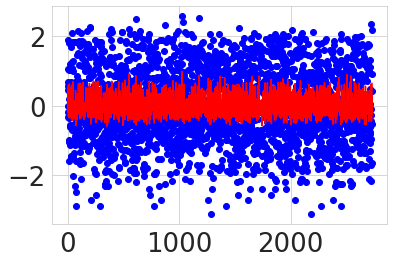

<Figure size 72000x72000 with 0 Axes>

In [ ]:
regr = ElasticNetCV(alphas = np.random.rand(1,100))
regr.fit(x_train, y_train)

ep = regr.predict(x_test)
x_ax = range(len(x_test))

print('Mean absolute error: ' + str(mean_absolute_error(y_test, ep)))
print('Mean Squared error: ' + str(mean_squared_error(y_test, ep)))
print('Explained Variance Score: ' + str(explained_variance_score(y_test, ep))) 
print('Max error: ' + str(max_error(y_test, ep)))
print('R2 Score: ' + str(r2_score(y_test, ep)))
print()

plt.scatter(x_ax,y_test, color='blue')
plt.plot(x_ax,ep, color='red')
plt.figure(figsize=(1000,1000))
plt.show()

In [ ]:
# Get the best parameters using random grid search for the Random Tree Reggressor
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestRegressor(bootstrap=True,max_samples=1210)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train,y_train)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 79.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 133.5min finished


{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1400}

Mean absolute error: 0.27573559413944077
Mean Squared error: 0.13152357106509913
Explained Variance Score: 0.8723892418219639
Max error: 2.318841360231308
R2 Score: 0.8723890065611783


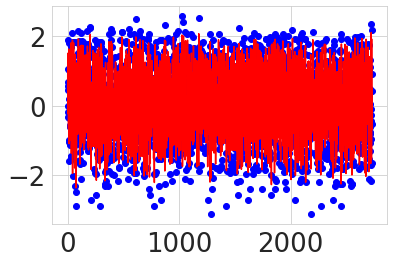

<Figure size 72000x720 with 0 Axes>

In [ ]:
randRegr = RandomForestRegressor(n_estimators=1400, min_samples_split=2,min_samples_leaf=1,max_features='sqrt',
                                 max_depth=100,bootstrap=True,max_samples=2360)
randRegr.fit(x_train, y_train)
randPre = randRegr.predict(x_test)

print('Mean absolute error: ' + str(mean_absolute_error(y_test, randPre)))
print('Mean Squared error: ' + str(mean_squared_error(y_test, randPre)))
print('Explained Variance Score: ' + str(explained_variance_score(y_test, randPre))) 
print('Max error: ' + str(max_error(y_test, randPre )))
print('R2 Score: ' + str(r2_score(y_test, randPre)))


plt.scatter(x_ax,y_test, color='blue')
plt.plot(x_ax,randPre, color='red')
plt.figure(figsize=(1000,10))
plt.show()

#### On Estimator Results

The RandomForestRegressor came out with drastically improved performance over the ElasticNetCV. This is even with the fact that both went through a process to find the best parameters to use. 

Feature Importance of the RandomForestRegressor dispalys the results below. 

In [ ]:
for feature, importance in zip(x.columns, regr.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feature, i=importance))

AttributeError: ignored

In [ ]:
for feature, importance in zip(x.columns, randRegr.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feature, i=importance))

## Verifying Robustness of Prediction Based on Causal Inference

While I was able to get great results with the RandomForestRegressor, I am not convinced that this model will accurately predict the followers from the given data. This is due to fact that this data is just the accounts that the popular simmers follow and not say those who follow them. 

Given this, I wanted to test the assumptions of this model and so I decided to run the models against the Causal Inference library doWhy to verifiy my skepticism. 

In [ ]:
casual_graph ="""digraph {
followers_count[label="Followers Count"];
friends_count[label="Friends Count"];
listed_count[label="Listed Count"];
account_age_in_days[label="Age in Days"];
favourites_count[label="favourites count"];
statuses_count[label="statuses count"];
PageRank[label="Page Rank"];
edgesToPopularSimmers[label="Edges To Popular Simmers"]
LocalClusteringCoefficient[label="LocalClusteringCoefficient"];
friends_count -> followers_count;
listed_count -> followers_count;
statuses_count -> followers_count;
PageRank -> followers_count;
favourites_count -> followers_count;
account_age_in_days -> followers_count;
edgesToPopularSimmers -> followers_count;
LocalClusteringCoefficient -> followers_count;
}"""

friendGraphModel = CausalModel(data = xWithFollowers, graph=casual_graph.replace("\n"," "),
                    treatment=['friends_count', 'listed_count', 'account_age_in_days', 
                               'favourites_count','statuses_count','PageRank','edgesToPopularSimmers', 'LocalClusteringCoefficient'], outcome='followers_count')

In [ ]:
friendGraphModelEstimand = friendGraphModel.identify_effect(proceed_when_unidentifiable=True)
friendGraphModelEstimate = friendGraphModel.estimate_effect(friendGraphModelEstimand,
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':RandomForestRegressor(),
                                                              'model_t': RandomForestRegressor(),
                                                              "model_final":ElasticNetCV(),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
friendGraphModelRandom = friendGraphModel.refute_estimate(friendGraphModelEstimand, friendGraphModelEstimate, method_name="random_common_cause", placebo_type="permute", num_simulations=100)
friendGraphModelSubset = friendGraphModel.refute_estimate(friendGraphModelEstimand, friendGraphModelEstimate, method_name="data_subset_refuter", placebo_type="permute", num_simulations=100)
friendGraphModelBootstrap = friendGraphModel.refute_estimate(friendGraphModelEstimand, friendGraphModelEstimate, method_name="bootstrap_refuter", placebo_type="permute", num_simulations=100)
friendGraphModelUnobserved = friendGraphModel.refute_estimate(friendGraphModelEstimand, friendGraphModelEstimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(friendGraphModelUnobserved)
print(friendGraphModelRandom)
print(friendGraphModelSubset)
print(friendGraphModelBootstrap)


In [ ]:
graph_renderer = from_networkx(friendGraph, nx.fruchterman_reingold_layout,
                               scale=1, center=(0,0))

In [ ]:
plot = Plot(plot_width=1000, plot_height=1000, x_range=Range1d(-1.1,1.1),
           y_range=Range1d(-1.1,1.1))
plot.title.text = "Popular Simmer Friend Graph"
plot.add_tools(HoverTool(tooltips=None),BoxSelectTool())
graph_renderer = from_networkx(friendGraph, nx.fruchterman_reingold_layout,
                                 scale=1, center=(0,0))
graph_renderer.node_renderer.glyph = Circle(size=5, fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size=5, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=5, fill_color=Spectral4[1])
graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8,
                                             line_width=5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2],
                                                       line_width=5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)
graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = EdgesAndLinkedNodes()
plot.renderers.append(graph_renderer)
output_notebook()
show(plot)

In [ ]:
nodesToRemove = [node for node in friendGraph.nodes if friendGraphStats[friendGraphStats['SimmerName'] != node].empty]
friendGraph.remove_nodes_from(nodesToRemove)

In [ ]:
layoutDict = graph_renderer.layout_provider.properties_with_values()
graphDict = layoutDict.get('graph_layout')
nodes_coordinate = graphDict.values()
nodes_coordinate = [x for x in nodes_coordinate]
graphDf = pd.DataFrame.from_dict(graphDict, orient='index',columns=['x','y'])
colorDf = pd.DataFrame.from_dict(nodeColor, orient='index',columns=['color'])
nodeEdgeDf = pd.DataFrame.from_dict(nodeEdgeCount, orient='index',columns=['EdgeCountTo'])

graphDf.reset_index(inplace=True)
colorDf.reset_index(inplace=True)
nodeEdgeDf.reset_index(inplace=True)

nodeColorsDf = pd.merge(graphDf,colorDf,left_on='index',right_on='index')
nodeColorsDf = pd.merge(nodeColorsDf, nodeEdgeDf, left_on='index',right_on='index')
nodeColorsDf = pd.merge(nodeColorsDf,friendGraphStats, left_on='index', right_on='SimmerName')
nodeColorsDf['SimmersName'] = nodeColorsDf['index']
nodeColorsDf = nodeColorsDf.set_index('index')
nodeColorsDf.drop(columns=['BetweenessCentrality', 'ClosenessCentrality','DegreeCentrality','EigenVectorCentrality',
                           'HarmonicClosenessCentrality','IsInLiner','KatzCentrality','LocalClusteringCoefficient',
                           'PageRank','SimmerName','created_at','favourites_count','listed_count','nodeId',
                           'statuses_count','verified','EdgeCountTo'],axis=1, inplace=True)
nodes_source = ColumnDataSource.from_df(nodeColorsDf)

In [ ]:
plot = figure(plot_width=1000, plot_height=1000, x_range=Range1d(-1.1,1.1),
            y_range=Range1d(-1.1,1.1))
plot.title.text = "Popular Simmer Friend Graph"
plot.add_tools(HoverTool(tooltips=[("SimmersName", "@SimmersName"),("Account Age(D)","@account_age_in_days"), ("Followers", "@followers_count"),
                                   ("Friends", "@friends_count"), ("Popular Simmer Followers", "@edgesToPopularSimmers")]),LassoSelectTool(),WheelZoomTool())

uniqEdgeCounts.sort()
for edges in uniqEdgeCounts:
  circleDf = nodeColorsDf.loc[nodeColorsDf['edgesToPopularSimmers'] == edges]
  plot.circle('x','y', source = ColumnDataSource.from_df(circleDf),size=10, fill_color='color',legend_label=str(edges))
plot.legend.location = 'top_left'
plot.legend.click_policy = 'hide'
plot.legend.title='Edge Count'

show(plot)

##Conclusions
Given the results of causal inference doWhy methods, I can not trust the results of either models that I trained to accurately predict the follower count from the data given. 

However, the analysis has yield some insights for next steps in my analysis. Using this data, it could be possible to segment the popular simmers by those they follow as a way to see how the different smaller communities of the simmer world intersect with each other. This way I can gain insights on the personality of the community as a whole. 

I can supplement this by adding the followers of these popular simmers to this graph. With this, I would like to see if there is a to do a 'Market Basket' analysis of the followers and who they choose to follow as well as who the popular simmers choose to follow. 